## 🧠 Convolutional Neural Network (CNN)

This notebook demonstrates how to build, train, and evaluate a **Convolutional Neural Network (CNN)** using **PyTorch** in the context of **machine reliability and maintenance**.

We will:
1. Simulate a small **synthetic 2D sensor dataset** representing vibration-temperature maps.
2. Build and train a CNN classifier to predict **Faulty** vs **Healthy** machines.
3. Evaluate the model (accuracy, confusion matrix, and loss curve).
4. Discuss how CNNs apply to real maintenance data such as thermal images or vibration spectrograms.

In [1]:
# Import required libraries
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### 1️⃣ Create a Synthetic Dataset

We will generate artificial **8x8 grayscale sensor maps**:
- **Healthy machines**: lower intensity, smooth readings.
- **Faulty machines**: higher intensity, noisy readings.

Each sample will be treated like a small image for CNN processing.

In [2]:
# Generate synthetic data
n_samples = 400
data, labels = [], []

for _ in range(n_samples):
    if np.random.rand() > 0.5:
        # Faulty sample: higher intensity, noisy pattern
        base = np.random.normal(0.7, 0.1, (8, 8))
        label = 1
    else:
        # Healthy sample: lower intensity, smooth pattern
        base = np.random.normal(0.3, 0.1, (8, 8))
        label = 0
    base = np.clip(base, 0, 1)
    data.append(base.astype(np.float32))
    labels.append(label)

# Convert to NumPy arrays and add channel dimension
data = np.expand_dims(np.array(data), axis=1)
labels = np.array(labels)

# Convert to PyTorch tensors
data_tensor = torch.tensor(data)
labels_tensor = torch.tensor(labels)

# Create dataset and split
dataset = TensorDataset(data_tensor, labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

Train size: 320, Test size: 80


#### Visualize samples

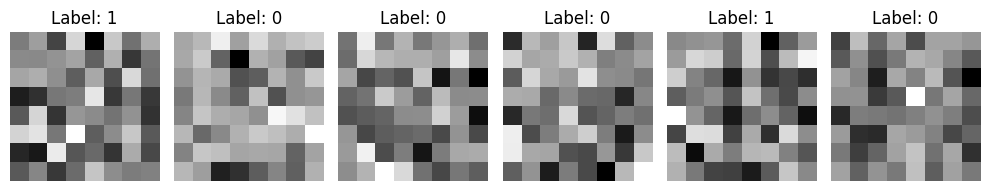

In [3]:
# Number of samples to display
num_samples = 6

# Randomly pick indices
indices = random.sample(range(len(data_tensor)), num_samples)

# Create a plot
plt.figure(figsize=(10, 2))
for i, idx in enumerate(indices):
    img = data_tensor[idx].squeeze()  # remove channel dimension (1, 8, 8)
    label = labels_tensor[idx].item()  # get label value

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### 2️⃣ Define the CNN Model

We'll define a **simple CNN** with two convolutional layers, ReLU activations, max-pooling, and a fully connected layer. This CNN architecture extracts features from 8×8 grayscale images using two convolution-pooling blocks, flattens the resulting feature maps, and classifies the image into one of two categories using a final fully connected layer.

In [4]:
# Define model using nn.Sequential
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(8, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 2 * 2, 2)
)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### CNN Architecture Explained (Line by Line)

| **Code Line** | **Explanation** |
|----------------|----------------|
| `model = nn.Sequential(` | Creates a sequential container to stack layers in order. |
| `nn.Conv2d(1, 8, kernel_size=3, padding=1),` | A 2D convolution layer that takes 1 input channel (grayscale image) and produces 8 output feature maps using 3×3 filters. Padding keeps the output size the same as the input. |
| `nn.ReLU(),` | Applies the Rectified Linear Unit activation function to introduce non-linearity, allowing the network to learn complex relationships. |
| `nn.MaxPool2d(2, 2),` | Performs max pooling over a 2×2 region with stride 2, reducing spatial dimensions by half while preserving the most important features. |
| `nn.Conv2d(8, 16, kernel_size=3, padding=1),` | A second convolutional layer that takes 8 input feature maps and outputs 16, enabling the model to detect more abstract and detailed features. |
| `nn.ReLU(),` | Applies ReLU activation again to add non-linearity after the second convolution. |
| `nn.MaxPool2d(2, 2),` | Another max pooling layer that further reduces the size of the feature maps, improving computational efficiency and feature generalization. |
| `nn.Flatten(),` | Converts the 2D feature maps into a 1D vector so the data can be fed into the fully connected layer. |
| `nn.Linear(16 * 2 * 2, 2)` | A fully connected layer that maps 64 input features (16 × 2 × 2) to 2 output values representing the prediction classes. |
| `)` | Closes the sequential model definition. |

### Show CNN layer-by-layer summary

In [5]:
from torchsummary import summary

summary(model, input_size=(1, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 8, 8]              80
              ReLU-2              [-1, 8, 8, 8]               0
         MaxPool2d-3              [-1, 8, 4, 4]               0
            Conv2d-4             [-1, 16, 4, 4]           1,168
              ReLU-5             [-1, 16, 4, 4]               0
         MaxPool2d-6             [-1, 16, 2, 2]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                    [-1, 2]             130
Total params: 1,378
Trainable params: 1,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


#### CNN Model Summary Explained

| Layer (Type) | Output Shape | Parameters | Explanation |
|------------------|------------------|----------------|-----------------|
| Conv2d-1 | `[-1, 8, 8, 8]` | 80 | The first convolutional layer converts 1-channel input into 8 feature maps using 3×3 kernels. Parameters = (1 × 3 × 3 × 8) + 8 biases = 80. |
| ReLU-2 | `[-1, 8, 8, 8]` | 0 | Applies the ReLU activation function, adding no learnable parameters. |
| MaxPool2d-3 | `[-1, 8, 4, 4]` | 0 | Performs 2×2 pooling, reducing spatial dimensions from 8×8 to 4×4 while keeping 8 feature maps. |
| Conv2d-4 | `[-1, 16, 4, 4]` | 1,168 | The second convolutional layer increases depth from 8 to 16 channels. Parameters = (8 × 3 × 3 × 16) + 16 biases = 1,168. |
| ReLU-5 | `[-1, 16, 4, 4]` | 0 | Applies another ReLU activation. |
| MaxPool2d-6 | `[-1, 16, 2, 2]` | 0 | Performs another 2×2 pooling, reducing dimensions to 2×2 with 16 channels. |
| Flatten-7 | `[-1, 64]` | 0 | Flattens the feature maps (16 × 2 × 2 = 64) into a 1D vector for the linear layer. |
| Linear-8 | `[-1, 2]` | 130 | Fully connected layer mapping 64 input features to 2 output classes. Parameters = (64 × 2) + 2 biases = 130. |


#### Model Statistics
- Total Parameters: 1,378 (all trainable)  
- Input Size: Very small (8×8 grayscale images)  
- Memory Footprint:  
  - Input: ~0 MB  
  - Forward/Backward Pass: ~0.01 MB  
  - Parameters: ~0.01 MB  
  - Total: ~0.02 MB  

#### Interpretation
This is a lightweight CNN with two convolutional and pooling layers followed by a single fully connected layer.  
It efficiently extracts low- and mid-level spatial features from small 8×8 grayscale inputs and outputs two class predictions, making it ideal for small-scale image classification or fault detection tasks.


### Visualize computational graph


✅ You will also need to install pygraphviz by runing the following code in Anaconda terminal: `conda install -c conda-forge pygraphviz`

✅ Install pygraphviz in Google Colab

1. Install Graphviz system libraries (including headers): `!apt-get install -y graphviz libgraphviz-dev`

2. Install pygraphviz from PyPI, specifying the include and library paths: `!pip install pygraphviz --no-binary pygraphviz`

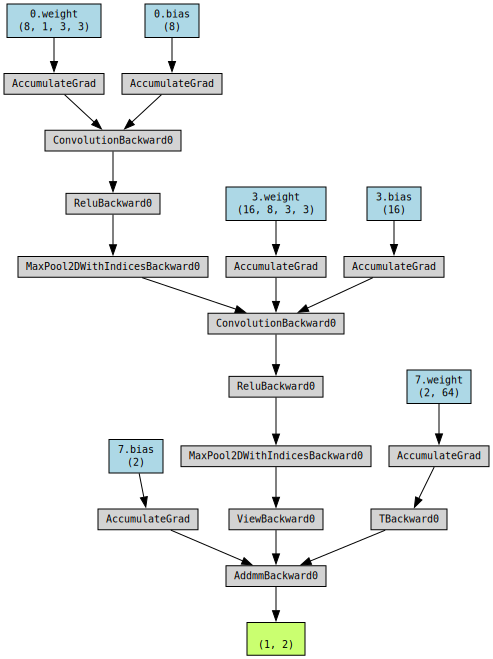

In [6]:
from torchviz import make_dot
dummy_input = torch.randn(1, 1, 8,8)
y = model(dummy_input)
make_dot(y, params=dict(model.named_parameters()))

### 3️⃣ Train the Model

Epoch 1/15, Loss: 0.6601
Epoch 2/15, Loss: 0.6174
Epoch 3/15, Loss: 0.5626
Epoch 4/15, Loss: 0.4879
Epoch 5/15, Loss: 0.3981
Epoch 6/15, Loss: 0.3027
Epoch 7/15, Loss: 0.2091
Epoch 8/15, Loss: 0.1304
Epoch 9/15, Loss: 0.0724
Epoch 10/15, Loss: 0.0387
Epoch 11/15, Loss: 0.0214
Epoch 12/15, Loss: 0.0131
Epoch 13/15, Loss: 0.0089
Epoch 14/15, Loss: 0.0064
Epoch 15/15, Loss: 0.0049


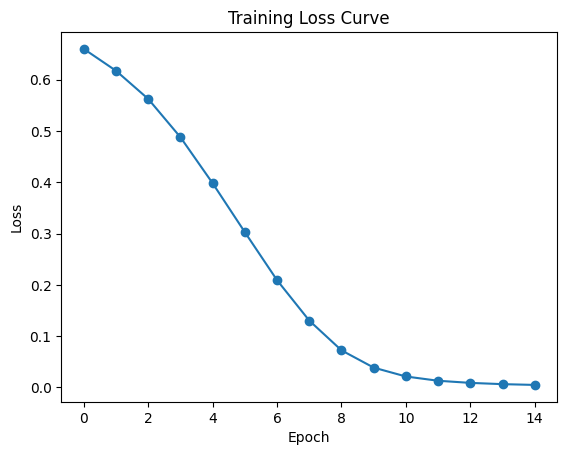

In [7]:
n_epochs = 15
train_losses = []

for epoch in range(n_epochs):
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {train_losses[-1]:.4f}')

plt.plot(train_losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### 4️⃣ Evaluate Model Performance

Test Accuracy: 100.00%


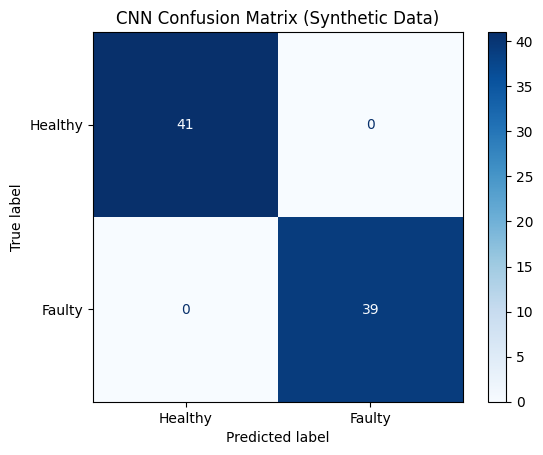

In [8]:
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Healthy','Faulty']).plot(cmap='Blues')
plt.title('CNN Confusion Matrix (Synthetic Data)')
plt.show()

### 5️⃣ Key Insights

- The CNN effectively distinguishes **healthy** and **faulty** patterns in synthetic sensor data.
- CNNs can learn **spatial correlations** from vibration, temperature, and acoustic maps.
- In real maintenance tasks, CNNs are used for:
  - Infrared thermal images (detect overheating)
  - Vibration spectrograms (detect bearing faults)
  - Acoustic images (detect air leaks or motor wear).

### ✅ Summary
- **CNNs** are powerful for detecting patterns in 2D sensor data.
- **Healthy vs Faulty** classification can use spatial sensor representations.
- This example shows the foundation for real-world predictive maintenance applications using PyTorch.